In [1]:
from astropy.modeling.models import Gaussian2D
from astropy.convolution import convolve

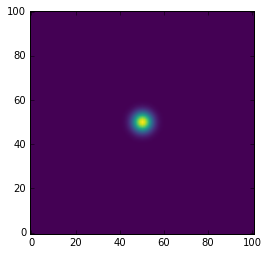

In [2]:
# create two 2D circular Gaussians
# high-res PSF: sigma = 3
# low-res PSF: sigma = 5
y, x = np.mgrid[0:101, 0:101]
gm1 = Gaussian2D(100, 50, 50, 3, 3)
gm2 = Gaussian2D(100, 50, 50, 5, 5)
g1 = gm1(x, y)
g2 = gm2(x, y)
g1 /= g1.sum()
g2 /= g2.sum()

# the matching kernel should be a Gaussian with sigma = 4
sig = np.sqrt(5**2 - 3**2)
gm3 = Gaussian2D(100, 50, 50, sig, sig)
g3 = gm3(x, y)
g3 /= g3.sum()

# high-res PSF
plt.imshow(g1)

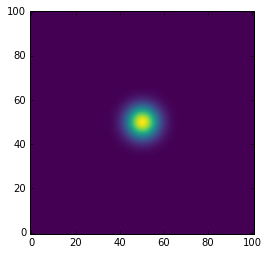

In [3]:
# low-res PSF
plt.imshow(g2)

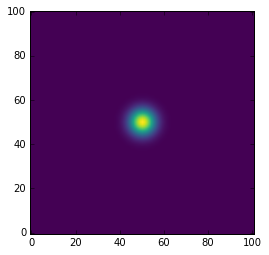

In [4]:
# expected matching kernel
plt.imshow(g3)

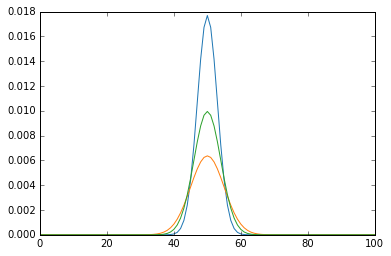

In [5]:
# 1D cuts
y0 = 50
plt.plot(g1[y0, :])
plt.plot(g2[y0, :])
plt.plot(g3[y0, :])

In [6]:
# convolve high-res PSF with matching kernel
g4 = convolve(g1, g3)

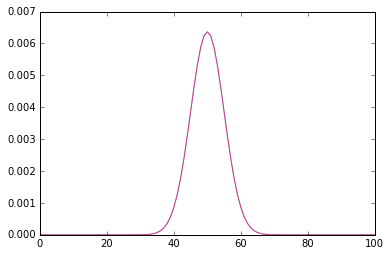

In [7]:
# result perfectly agrees with low-res PSF
plt.plot(g2[y0, :], color='blue', alpha=0.5)
plt.plot(g4[y0, :], color='red', alpha=0.5)

In [8]:
# compute the ratio of FFTs
from numpy.fft import fft2, ifft2, fftshift, ifftshift
f1 = fftshift(np.abs(fft2(g1)))
f2 = fftshift(np.abs(fft2(g2)))
fr = f2 / f1

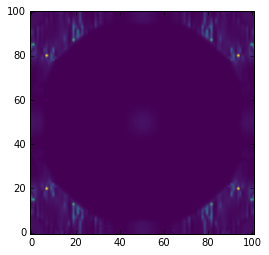

In [9]:
# display the ratio
plt.imshow(fr)

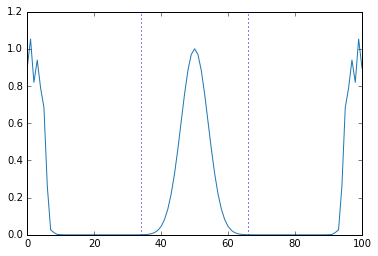

In [10]:
# the desired signal is in the center
plt.plot(fr[y0, :])
cutoff = 16
plt.axvline(50-cutoff, ls='dotted')
plt.axvline(50+cutoff, ls='dotted')

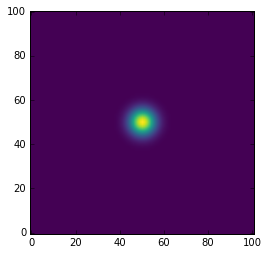

In [11]:
# apply a simple radial cutoff
position = (50, 50)
shape = (101, 101)
x = np.arange(shape[1]) - position[1]
y = np.arange(shape[0]) - position[0]
xx, yy = np.meshgrid(x, y)
r1 = np.sqrt(xx**2 + yy**2)

fr[r1 > cutoff] = 0.

# display the windowed FFT ratio
plt.imshow(fr)

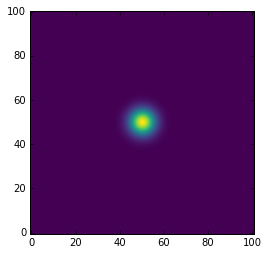

In [12]:
# calculate the matching kernel
kernel = fftshift(np.abs(ifft2(ifftshift(fr))))
plt.imshow(kernel)

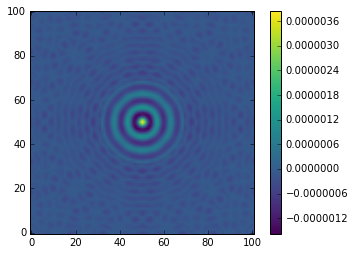

In [13]:
# residuals from expected kernel
plt.imshow(g3 - kernel)
plt.colorbar()

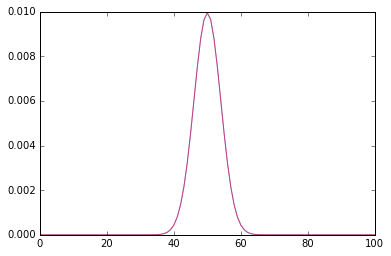

In [14]:
# 1D cuts
plt.plot(kernel[y0, :], color='blue', alpha=0.5)
plt.plot(g3[y0, :], color='red', alpha=0.5)

In [15]:
from astropy.modeling import fitting
from astropy.modeling.models import Gaussian2D
fitter = fitting.LevMarLSQFitter()
g_init = Gaussian2D(1, 50, 50, 5, 5)
y, x = np.mgrid[0:101, 0:101]
g_fit = fitter(g_init, x, y, kernel)
g_fit

<Gaussian2D(amplitude=0.009947158539740514, x_mean=50.0, y_mean=50.0, x_stddev=4.000009630132441, y_stddev=4.000009630132441, theta=0.00036492778376537673)>

In [16]:
# indeed, the matching kernel is a 2D Gaussian with sigma=4 (as expected)